# Perform PCA/subspace overlap analysis on single subject data

In [1]:
import pickle
from dPCA import dPCA
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def pickle_this(thing_to_pickle, file_name):
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    with open(pickle_file, 'rb') as file:
        return pickle.load(file)

# Ephys Recording Object: Phase 2 (Freely moving)

Each recording is an ephysrecording instance; the documentation is as follows: 

A class for an ephys recording after being spike sorted and manually
curated using phy. Ephys recording must have a phy folder.


    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        subject: str, subject id who was being recorded
        event_dict: dict, start and stop times for events
            keys: str, name of event types
            values: np.array, d =(n,2), each 2D array is the start and stop time 
            in ms for each event, n = number of events of type key
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        timestamps_var: numpy array, all spike timestamps
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes
            from "good" units only
        spiketrain: np.array, spiketrain of number of spikes
            in a specified timebin
        unit_spiketrains: dict, spiketrains for each unit
            keys: str, unit ids
            values: np.array, number of spikes per specified timebin
        unit_firing_rates: dict, firing rates per unit
            keys: str, unit ids
            values: np.arrays, firing rate of unit in a specified timebin
                    calculated with a specified smoothing window

    Methods: (all called in __init__)
        get_unit_labels: creates labels_dict
        get_spike_specs: creates timestamps_var and unit_array
        get_unit_timestamps: creates unit_timestamps dictionary


All recordings have been put into an instance of the class type ephysrecordingcollection.
Big picture is that phase2_collection has an attribute called collection which is a dictionary of 
recording names: recording objects. 

In [3]:
phase2_collection = unpickle_this('phase2collection.pkl')

In [4]:
is_first = True
for recording_name, recording in phase2_collection.collection.items():
    if is_first:
        print('Example recording:')
        print(recording_name)
        print("")
        print('Event Types:')
        print(recording.event_dict.keys())
        print("")
        print('Number of units:')
        print(len(recording.unit_timestamps.keys()))
        is_first = False

Example recording:
20230803_101331_1_merged.rec

Event Types:
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])

Number of units:
52


In [5]:
phase2_collection.collection.items()

dict_items([('20230803_101331_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000002337CBCBA90>), ('20230803_121318_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000002330A0FF040>), ('20230803_141047_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000002331095ACB0>), ('20230804_121600_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000002330DDA6980>), ('20230804_141009_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000002331DD67BE0>), ('20230817_100823_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x00000233226CC3D0>), ('20230817_113746_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000002331628EB30>), ('20230818_115728_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x000002332D8844C0>), ('20230818_133620_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x00000233326ED390>)

# Spike Analysis Object

Here is another class I made for spike analysis specifically. 

Parameters that you should feel free to play with are smoothin_window and timebin (both in ms).

    Timebin:
        window for each element in all the arrays (spiketrains, firing rates, etc.).
    Smoothing window:
        the rolling average window size to be used when calculating firing rates. 

In [36]:
# Spiking analysis parameters
# phase2_analysis = spike.SpikeAnalysis_MultiRecording(
#     phase2_collection,
#     smoothing_window = 250, #100
#     timebin = 100, #50
#     ignore_freq = 0.5)

# PCA analysis parameters
phase2_analysis = spike.SpikeAnalysis_MultiRecording(
    phase2_collection,
    smoothing_window = 500, #100
    timebin = 50, #40
    ignore_freq = 0.5)

All set to analyze


# Single recording

In [37]:
recordings = phase2_analysis.ephyscollection.collection.items()
equalize = 3 ; pre_window = 1 ; post_window = 0
events = ['recall', 'cagemate', 'novel']
for recording_name, recording in recordings:

    if (recording.subject != '1.4') or (recording_name != '20230804_121600_1_merged.rec'):
        continue

    print(recording_name)
    print(recording.subject)

    first_event = True
    temp_spike_events = []
    temp_avg_events = []
    combavg = []
    for event in events:
        
        print(event)
    
        if first_event:
            event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            print(event_firing_rates.shape)
            event_averages = np.mean(event_firing_rates, axis = 0) 
            print(event_averages.shape)
            temp_avg_events.append(event_averages)
            all_event_avgs = event_averages
            all_event_firing_rates = event_firing_rates
            print(all_event_firing_rates.shape)
            first_event = False
        else:
            event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            print(event_firing_rates.shape)
            event_averages = np.mean(event_firing_rates, axis = 0) 
            print(event_averages.shape)
            temp_avg_events.append(event_averages)
            # event_firing_rates_reshape = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
            # print(event_firing_rates_reshape.shape)
            all_event_avgs = np.concatenate((all_event_avgs, event_averages), axis=0)
            all_event_firing_rates = np.concatenate((all_event_firing_rates, event_firing_rates), axis=0)
        print(all_event_firing_rates[:7].shape)
        temp_spike_events.append(all_event_firing_rates[:7])
        combavg.append(all_event_avgs)
        # break
    comb_trials = np.concatenate((temp_spike_events[0], temp_spike_events[1], temp_spike_events[2]), axis=2)
    print(comb_trials.shape)
    comb_avgtrials = np.concatenate((temp_avg_events[0], temp_avg_events[1], temp_avg_events[2]), axis=1)
    print(comb_avgtrials.shape)
    print(combavg[2].shape)
    break

20230804_121600_1_merged.rec
1.4
recall
(11, 28, 80)
(28, 80)
(11, 28, 80)
(7, 28, 80)
cagemate
(12, 28, 80)
(28, 80)
(7, 28, 80)
novel
(8, 28, 80)
(28, 80)
(7, 28, 80)
(7, 28, 240)
(28, 240)
(84, 80)


In [38]:
ST = pd.DataFrame(combavg[0])
LT = pd.DataFrame(combavg[1])
novel = pd.DataFrame(combavg[2])

## PCA

### Functions

In [39]:
def extract_relativevar(matrix1_df, matrix2_df, n_comp): # with respect to matrix1 (fit PCA to matrix1)
    pca = PCA(n_components=n_comp)
    pca.fit(matrix1_df.values)
    matrix1_mean = matrix1_df.values-np.mean(matrix1_df.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    inv_matrix1 = pca.inverse_transform(trans_matrix1)
    matrix1_var = np.sum(np.matrix.var(np.asmatrix(inv_matrix1), axis=0))/np.sum(np.matrix.var(np.asmatrix(matrix1_mean), axis=0))
    matrix2_mean = matrix2_df.values-np.mean(matrix2_df.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)
    inv_matrix2 = pca.inverse_transform(trans_matrix2)
    matrix2_var = np.sum(np.matrix.var(np.asmatrix(inv_matrix2), axis=0))/np.sum(np.matrix.var(np.asmatrix(matrix2_mean), axis=0))
    return matrix1_var, matrix2_var

def plot_relativevar(matrix1_df, matrix2_df, n_comp, c1, c2):
    matrix1_vars = [] ; matrix2_vars = []
    for i in range(n_comp+1):
        matrix1_var, matrix2_var = extract_relativevar(matrix1_df, matrix2_df, i)
        matrix1_vars.append(matrix1_var) ; matrix2_vars.append(matrix2_var)

    matrix1_contribute = [matrix1_vars[i]-matrix1_vars[i-1] for i in range(len(matrix1_vars)) if i!=0]
    matrix2_contribute = [matrix2_vars[i]-matrix2_vars[i-1] for i in range(len(matrix2_vars)) if i!=0]

    fig, ax = plt.subplots()
    # create data
    x = np.arange(n_comp)
    width = 0.40
    # plot data in grouped manner of bar type 
    plt.bar(x-0.2, matrix1_contribute, width, color=c1)
    plt.bar(x+0.2, matrix2_contribute, width, color=c2)
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0,1,0.1))

    plt.show()

In [40]:
def plot_3DPCA(matrix1, matrix2, n_components, mat1color, mat2color):
    # fit to matrix 1
    pca = PCA(n_components=n_components)
    pca.fit(matrix1.values)
    matrix1_mean = matrix1.values-np.mean(matrix1.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    matrix2_mean = matrix2.values-np.mean(matrix2.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)

    fig = plt.figure(figsize = (10, 13))
    ax = fig.add_subplot(121, projection="3d")
    ax.scatter(trans_matrix1[:,0], trans_matrix1[:,1], trans_matrix1[:,2], color=mat1color)
    ax.scatter(trans_matrix2[:,0], trans_matrix2[:,1], trans_matrix2[:,2], color=mat2color)

    # fit to matrix 2
    pca = PCA(n_components=n_components)
    pca.fit(matrix2.values)
    matrix1_mean = matrix1.values-np.mean(matrix1.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    matrix2_mean = matrix2.values-np.mean(matrix2.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)

    ax = fig.add_subplot(122, projection="3d")
    ax.scatter(trans_matrix1[:,0], trans_matrix1[:,1], trans_matrix1[:,2], color=mat1color)
    ax.scatter(trans_matrix2[:,0], trans_matrix2[:,1], trans_matrix2[:,2], color=mat2color)

    plt.show()

In [41]:
LT

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.363636,0.363636,0.181818,0.181818,0.181818,0.181818,0.181818,0.363636,0.363636,0.363636,...,0.909091,0.545455,0.545455,0.727273,0.909091,0.909091,1.090909,1.272727,1.272727,1.636364
1,64.181818,66.000000,67.636364,67.818182,69.090909,69.090909,68.545455,69.636364,70.181818,70.727273,...,55.090909,57.454545,55.818182,55.454545,55.090909,53.636364,53.636364,52.909091,51.818182,53.090909
2,8.545455,8.363636,8.363636,8.000000,7.272727,7.454545,7.636364,7.636364,7.636364,8.545455,...,4.363636,4.181818,4.181818,3.818182,3.454545,4.181818,4.000000,3.272727,3.090909,3.272727
3,7.454545,7.090909,6.181818,6.363636,5.818182,6.363636,6.000000,4.909091,6.000000,6.363636,...,4.909091,4.727273,4.363636,3.090909,3.454545,3.636364,3.636364,4.000000,3.818182,3.636364
4,5.454545,5.454545,5.454545,4.727273,4.727273,4.545455,4.545455,4.909091,4.727273,5.090909,...,4.727273,4.363636,3.636364,4.000000,3.636364,4.000000,4.363636,4.363636,4.545455,4.727273
5,0.000000,0.000000,0.181818,0.181818,0.181818,0.181818,0.363636,0.363636,0.545455,0.545455,...,1.090909,1.272727,1.636364,1.090909,1.090909,1.090909,1.454545,1.454545,1.636364,1.818182
6,3.636364,3.454545,3.272727,3.272727,2.909091,3.454545,3.454545,3.272727,3.454545,2.909091,...,4.363636,4.363636,4.181818,4.545455,4.909091,4.363636,4.000000,3.636364,3.818182,3.636364
7,22.000000,23.272727,23.818182,24.545455,25.272727,23.272727,24.181818,24.000000,24.727273,25.272727,...,23.090909,21.818182,22.181818,23.272727,22.000000,22.909091,22.363636,21.636364,22.909091,22.909091
8,1.818182,1.818182,1.818182,1.818182,2.545455,2.363636,2.181818,2.181818,2.181818,2.545455,...,1.636364,1.636364,1.636364,1.636364,2.000000,2.181818,1.636364,2.000000,2.000000,2.000000
9,1.090909,0.909091,1.272727,0.909091,0.909091,0.909091,1.272727,1.090909,1.272727,0.909091,...,2.000000,2.000000,1.818182,1.454545,1.454545,1.454545,1.454545,1.454545,1.272727,0.909091


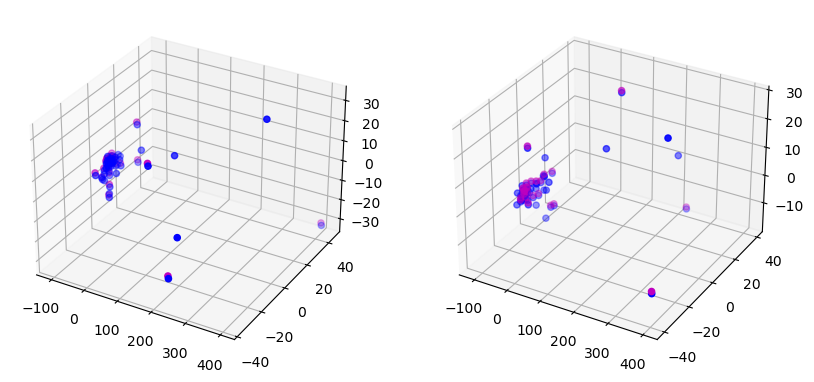

In [42]:
plot_3DPCA(LT, ST, 3, 'b', 'm')

### Code

In [43]:
n_components = 5

In [44]:
pca = PCA(n_components=n_components)
pca.fit(LT.values)
print(pca.explained_variance_ratio_)

[9.80037159e-01 9.56439663e-03 6.00216697e-03 2.05393280e-03
 8.98952427e-04]


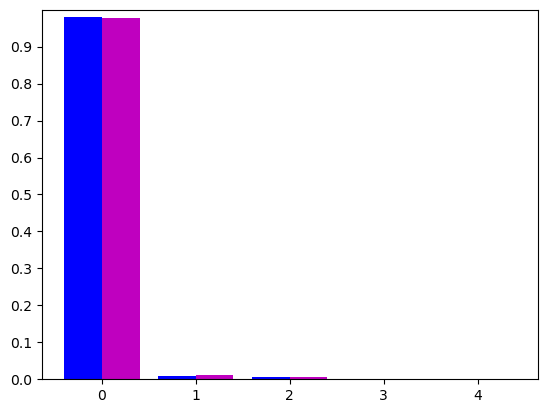

In [45]:
plot_relativevar(LT, ST, n_components, 'blue', 'm')

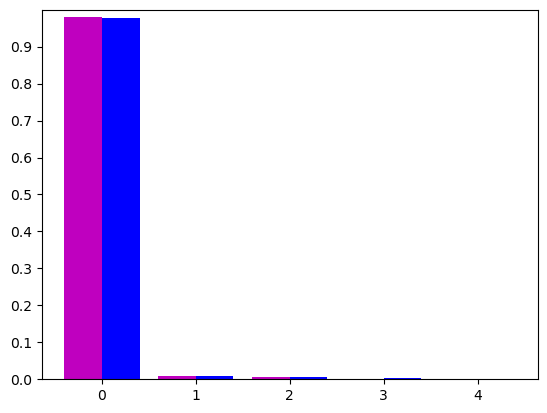

In [46]:
plot_relativevar(LT, novel, n_components, 'm', 'b')

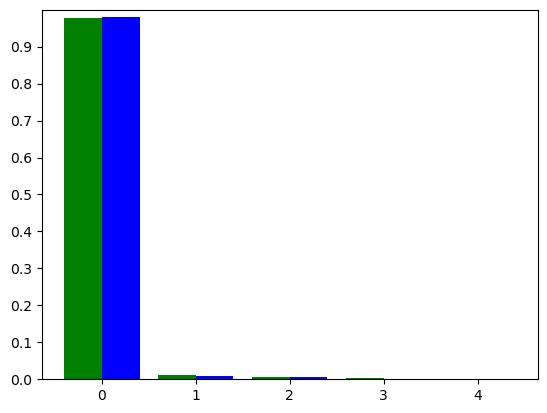

In [47]:
plot_relativevar(novel, LT, n_components, 'g', 'b')

In [48]:
pca = PCA(n_components=n_components)
pca.fit(novel.values)
print(pca.explained_variance_ratio_)

[0.97776589 0.01029022 0.00575087 0.00258809 0.00119143]


## CCA

In [49]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(LT.iloc[:28], ST)

# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(LT.iloc[:28], ST)
 
# Score the CCA model
LTST_score = cca.score(LT.iloc[:28], ST)
 
# Print the score
print(LTST_score)

0.9857199325631278


In [50]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(LT, novel.iloc[:56])

# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(LT, novel.iloc[:56])
 
# Score the CCA model
LTnov_score = cca.score(LT, novel.iloc[:56])
 
# Print the score
print(LTnov_score)

0.9765213272702713


In [51]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(ST, novel.iloc[:28])

# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(ST, novel.iloc[:28])
 
# Score the CCA model
STnov_score = cca.score(ST, novel.iloc[:28])
 
# Print the score
print(STnov_score)

0.9857199325631278


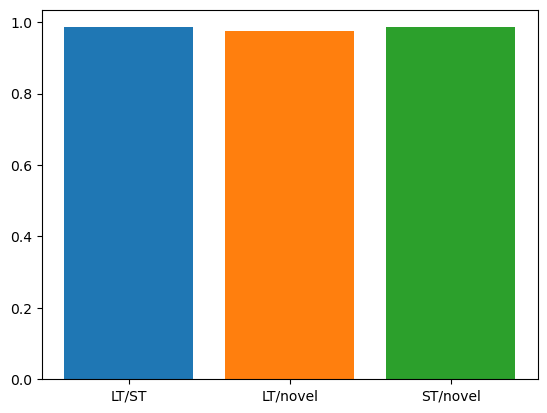

In [52]:
fig, ax = plt.subplots()
plt.bar(1,LTST_score)
plt.bar(2, LTnov_score)
plt.bar(3, STnov_score)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["LT/ST", "LT/novel", 'ST/novel'])
plt.show()

# All recordings

In [53]:
recordings = phase2_analysis.ephyscollection.collection.items()
equalize = 2 ; pre_window = 3 ; post_window = 0
events = ['recall', 'cagemate', 'novel']

combavg = []
for recording_name, recording in recordings:

    if (recording.subject != '1.4'):
        continue

    print(recording_name)
    print(recording.subject)

    first_event = True
    temp_spike_events = []
    temp_avg_events = []
    for event in events:
        
        print(event)
    
        if first_event:
            event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            print(event_firing_rates.shape)
            event_averages = np.mean(event_firing_rates, axis = 0) 
            print(event_averages.shape)
            temp_avg_events.append(event_averages)
            all_event_avgs = event_averages
            all_event_firing_rates = event_firing_rates
            print(all_event_firing_rates.shape)
            first_event = False
        else:
            event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
            event_firing_rates = np.array(event_firing_rates)
            print(event_firing_rates.shape)
            event_averages = np.mean(event_firing_rates, axis = 0) 
            print(event_averages.shape)
            temp_avg_events.append(event_averages)
            # event_firing_rates_reshape = np.reshape(event_firing_rates, (event_firing_rates.shape[0], event_firing_rates.shape[1], 1, event_firing_rates.shape[2]))
            # print(event_firing_rates_reshape.shape)
            all_event_avgs = np.concatenate((all_event_avgs, event_averages), axis=0)
            all_event_firing_rates = np.concatenate((all_event_firing_rates, event_firing_rates), axis=0)
        print(all_event_firing_rates[:7].shape)
        temp_spike_events.append(all_event_firing_rates[:7])
        combavg.append(all_event_avgs)
        # break
    # comb_trials = np.concatenate((temp_spike_events[0], temp_spike_events[1], temp_spike_events[2]), axis=2)
    # print(comb_trials.shape)
    # comb_avgtrials = np.concatenate((temp_avg_events[0], temp_avg_events[1], temp_avg_events[2]), axis=1)
    # print(comb_avgtrials.shape)
print(len(combavg))
    # break

20230803_121318_1_merged.rec
1.4
recall
(6, 19, 100)
(19, 100)
(6, 19, 100)
(6, 19, 100)
cagemate
(7, 19, 100)
(19, 100)
(7, 19, 100)
novel
(9, 19, 100)
(19, 100)
(7, 19, 100)
20230804_121600_1_merged.rec
1.4
recall
(11, 28, 100)
(28, 100)
(11, 28, 100)
(7, 28, 100)
cagemate
(12, 28, 100)
(28, 100)
(7, 28, 100)
novel
(8, 28, 100)
(28, 100)
(7, 28, 100)
20230818_133620_1_merged.rec
1.4
recall
(6, 30, 100)
(30, 100)
(6, 30, 100)
(6, 30, 100)
cagemate
(11, 30, 100)
(30, 100)
(7, 30, 100)
novel
(10, 30, 100)
(30, 100)
(7, 30, 100)
9


In [54]:
ST_temp = [pd.DataFrame(i) for i in combavg[0::3]]
LT_temp = [pd.DataFrame(i) for i in combavg[1::3]]
novel_temp = [pd.DataFrame(i) for i in combavg[2::3]]

ST = pd.DataFrame(np.concatenate(ST_temp))
LT = pd.DataFrame(np.concatenate(LT_temp))
novel = pd.DataFrame(np.concatenate(novel_temp))

In [55]:
ST.shape

(77, 100)

# PCA

## Functions

In [56]:
def extract_relativevar(matrix1_df, matrix2_df, n_comp): # with respect to matrix1 (fit PCA to matrix1)
    pca = PCA(n_components=n_comp)
    pca.fit(matrix1_df.values)
    matrix1_mean = matrix1_df.values-np.mean(matrix1_df.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    inv_matrix1 = pca.inverse_transform(trans_matrix1)
    matrix1_var = np.sum(np.matrix.var(np.asmatrix(inv_matrix1), axis=0))/np.sum(np.matrix.var(np.asmatrix(matrix1_mean), axis=0))
    matrix2_mean = matrix2_df.values-np.mean(matrix2_df.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)
    inv_matrix2 = pca.inverse_transform(trans_matrix2)
    matrix2_var = np.sum(np.matrix.var(np.asmatrix(inv_matrix2), axis=0))/np.sum(np.matrix.var(np.asmatrix(matrix2_mean), axis=0))
    return matrix1_var, matrix2_var

def plot_relativevar(matrix1_df, matrix2_df, n_comp, c1, c2):
    matrix1_vars = [] ; matrix2_vars = []
    for i in range(n_comp+1):
        matrix1_var, matrix2_var = extract_relativevar(matrix1_df, matrix2_df, i)
        matrix1_vars.append(matrix1_var) ; matrix2_vars.append(matrix2_var)

    matrix1_contribute = [matrix1_vars[i]-matrix1_vars[i-1] for i in range(len(matrix1_vars)) if i!=0]
    matrix2_contribute = [matrix2_vars[i]-matrix2_vars[i-1] for i in range(len(matrix2_vars)) if i!=0]

    fig, ax = plt.subplots()
    # create data
    x = np.arange(n_comp)
    width = 0.40
    # plot data in grouped manner of bar type 
    plt.bar(x-0.2, matrix1_contribute, width, color=c1)
    plt.bar(x+0.2, matrix2_contribute, width, color=c2)
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0,1,0.1))

    plt.show()

def plot_3DPCA(matrix1, matrix2, n_components, mat1color, mat2color):
    # fit to matrix 1
    pca = PCA(n_components=n_components)
    pca.fit(matrix1.values)
    matrix1_mean = matrix1.values-np.mean(matrix1.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    matrix2_mean = matrix2.values-np.mean(matrix2.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)

    fig = plt.figure(figsize = (10, 13))
    ax = fig.add_subplot(121, projection="3d")
    ax.scatter(trans_matrix1[:,0], trans_matrix1[:,1], trans_matrix1[:,2], color=mat1color)
    ax.scatter(trans_matrix2[:,0], trans_matrix2[:,1], trans_matrix2[:,2], color=mat2color)

    # fit to matrix 2
    pca = PCA(n_components=n_components)
    pca.fit(matrix2.values)
    matrix1_mean = matrix1.values-np.mean(matrix1.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    matrix2_mean = matrix2.values-np.mean(matrix2.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)

    ax = fig.add_subplot(122, projection="3d")
    ax.scatter(trans_matrix1[:,0], trans_matrix1[:,1], trans_matrix1[:,2], color=mat1color)
    ax.scatter(trans_matrix2[:,0], trans_matrix2[:,1], trans_matrix2[:,2], color=mat2color)

    plt.show()

## Code

In [57]:
n_components = 5

In [58]:
pca = PCA(n_components=n_components)
pca.fit(LT.values)
print(pca.explained_variance_ratio_)

[0.97301367 0.01218993 0.00422971 0.00325939 0.00166832]


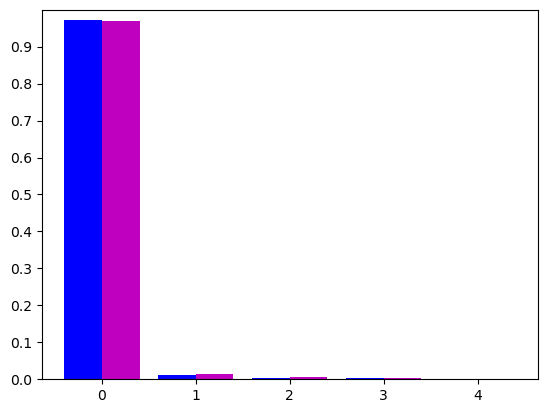

In [59]:
plot_relativevar(LT, ST, n_components, 'blue', 'm')

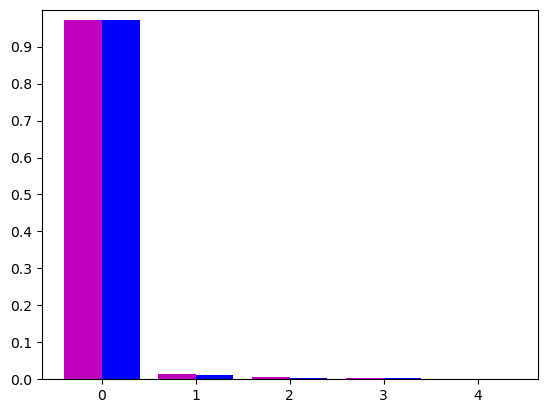

In [60]:
plot_relativevar(ST, LT, n_components, 'm', 'b')

In [61]:
pca = PCA(n_components=n_components)
pca.fit(novel.values)
print(pca.explained_variance_ratio_)

[0.97164386 0.01478303 0.00368163 0.00247408 0.0016335 ]


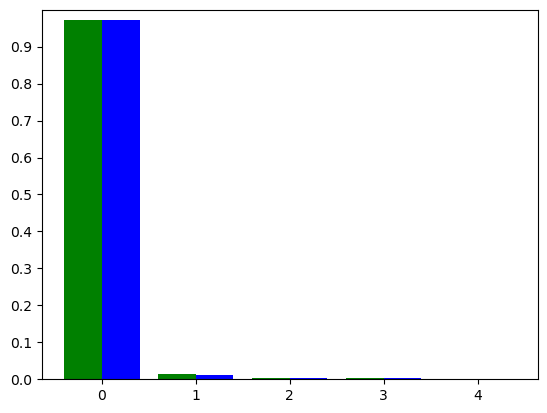

In [62]:
plot_relativevar(novel, LT, n_components, 'g', 'b')

# CCA

In [63]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(LT.iloc[:77], ST)

# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(LT.iloc[:77], ST)
 
# Score the CCA model
LTST_score = cca.score(LT.iloc[:77], ST)
 
# Print the score
print(LTST_score)

0.020011948212529697


In [64]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(LT, novel.iloc[:154])

# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(LT, novel.iloc[:154])
 
# Score the CCA model
LTnov_score = cca.score(LT, novel.iloc[:154])
 
# Print the score
print(LTnov_score)

0.40384070407868866


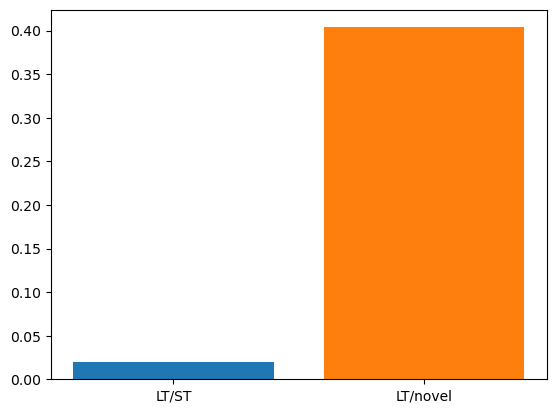

In [65]:
fig, ax = plt.subplots()
plt.bar(1,LTST_score)
plt.bar(2, LTnov_score)
ax.set_xticks([1, 2])
ax.set_xticklabels(["LT/ST", "LT/novel"])
plt.show()